In [35]:
# importing libraries
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [36]:
data_path = os.path.join(os.getcwd(), 'ynap_data')
print(data_path)

/nfs/science/shared/ipythonNotebooks/leom/Kaggle/Ynap-master/ynap_data


In [37]:
print(os.listdir(data_path))

['transactions.csv', '~$sk_overview.docx', 'df_quarterly.csv', 'df_monthly.csv', 'account.csv', 'Thumbs.db', 'df_tot.csv']


In [38]:
df_acc = pd.read_csv(os.path.join(data_path, 'account.csv'), sep=',')
df_acc.head()

,customer_id,var3,var4,var5,var6,lapsed_next_period
0,553547,3.0,0.34,0.0,0.0,0
1,213578,3.0,0.11,0.0,0.0,0
2,906135,3.0,0.05,0.0,0.0,0
3,226782,2.0,0.01,0.0,0.0,0
4,103600,2.0,0.33,1.0,0.0,0


In [39]:
df_trans = pd.read_csv(os.path.join(data_path, 'transactions.csv'), sep=',')
df_trans.head()

,customer_id,order_id,order_date,var1,var2,product_id,product_type_id,designer_id,gross_spend,net_spend
0,553547,235052,1989-08-28,0,0,96141,66,2262,1.304,1.304
1,553547,235052,1989-08-28,0,0,965607,44,2288,0.015,0.015
2,213578,335391,1990-09-02,1,0,13263,139,322,0.328,0.000
3,213578,50811,1990-11-23,1,0,596855,188,578,0.095,0.095
4,213578,50811,1990-11-23,1,0,779370,188,578,0.081,0.081


In [40]:
# shape dataframes
print('account dataframe dim: ({:,}, {:,})'.format(df_acc.shape[0], df_acc.shape[1]))
print('transactions dataframe dim: ({:,}, {:,})'.format(df_trans.shape[0], df_trans.shape[1]))

account dataframe dim: (15,695, 6)
transactions dataframe dim: (1,447,780, 10)


In [41]:
# check if customers are distinct
df_trans['customer_id'].nunique()

15695

In [42]:
# chrun rate
print(df_acc['lapsed_next_period'].value_counts())
print('\nChurn rate: {:.2%}'.format(df_acc['lapsed_next_period'].sum() / df_acc['customer_id'].nunique()))

0    14874
1      821
Name: lapsed_next_period, dtype: int64

Churn rate: 5.23%


In [43]:
# var1 and var2
print(df_trans['var1'].value_counts())
print(df_trans['var1'].value_counts(normalize=True))
print(df_trans['var2'].value_counts())
print(df_trans['var2'].value_counts(normalize=True))

0    1316219
1     131561
Name: var1, dtype: int64
0    0.909129
1    0.090871
Name: var1, dtype: float64
0    933749
1    514031
Name: var2, dtype: int64
0    0.644952
1    0.355048
Name: var2, dtype: float64


In [44]:
# convert order_date from str to datetime
df_trans['order_date'] = df_trans['order_date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [45]:
def get_periods(df):
    df['order_month'] = df['order_date'].apply(lambda x: str(x.date().year) + str(x.date().month).zfill(2))
    df['order_quarter'] = df['order_date'].apply(lambda x: str(x.date().year) + str((x.date().month-1)//3+1).zfill(2))
    
get_periods(df_trans)

In [48]:
# period of transactions
print('first transactions: {:%d %B %Y}'.format(df_trans['order_date'].min()))
print('last transactions: {:%d %B %Y}'.format(df_trans['order_date'].max()))
print(df_trans['order_date'].max()-df_trans['order_date'].min())

first transactions: 01 July 1989
last transactions: 30 December 1990
547 days 00:00:00


In [49]:
# get items returned
df_trans['item_returned'] = df_trans['net_spend'].apply(lambda x: 1 if x == 0 else 0)
df_trans['item_bought'] = df_trans['net_spend'].apply(lambda x: 0 if x == 0 else 1)

In [50]:
df_trans.head()

,customer_id,order_id,order_date,var1,var2,product_id,product_type_id,designer_id,gross_spend,net_spend,order_month,order_quarter,item_returned,item_bought
0,553547,235052,1989-08-28,0,0,96141,66,2262,1.304,1.304,198908,198903,0,1
1,553547,235052,1989-08-28,0,0,965607,44,2288,0.015,0.015,198908,198903,0,1
2,213578,335391,1990-09-02,1,0,13263,139,322,0.328,0.000,199009,199003,1,0
3,213578,50811,1990-11-23,1,0,596855,188,578,0.095,0.095,199011,199004,0,1
4,213578,50811,1990-11-23,1,0,779370,188,578,0.081,0.081,199011,199004,0,1


In [71]:
# check items
# prod_order = df_trans[['order_id', 'product_id']].sort_values(['product_id', 'order_id'])
# poc = prod_order.groupby('product_id').count().reset_index()
# pocd = prod_order.groupby('product_id')['order_id'].nunique().reset_index()

# po = poc.join(pocd, rsuffix='_dist')
# po[po['order_id'] != po['order_id_dist']]

# df_trans[df_trans['product_id'] == 381].sort_values(['order_id'])

In [88]:
def column_finder(df, col, method=2):
    if method == 1:
        # method 1:
        cols_as_string = ' '.join(df.columns.values)
        cols_found = list(re.findall(col + '.*?\ ', cols_as_string))
        cols_found = [x.strip(' ') for x in cols_found]
    elif method == 2:
        # method 2:
        cols_found = []
        for col_elem in df.columns.values:
            if col in col_elem:
                cols_found.append(col_elem)
    else:
        raise ValueError
            
    return cols_found

def get_piv_counts_and_sums(df, grouping_columns='customer_id'):
    
    dist_count_cols = ['order_id', 'product_id', 'product_type_id', 'designer_id']
    count_cols = ['var1', 'var2']
    sum_cols = ['gross_spend', 'net_spend', 'item_bought', 'item_returned', 'var1', 'var2']
    
    # maybe not necessary
    if type(grouping_columns) != list:
        glist = []
        glist.append(grouping_columns)
    else:
        glist = grouping_columns
   
    get_dist_counts = df.groupby(glist)[dist_count_cols].nunique().reset_index()
    get_counts = df.groupby(glist)[count_cols].count().reset_index()
    get_sums = df.groupby(glist)[sum_cols].sum().reset_index()
    get_sums = get_sums.rename(columns = {'var1': 'var1_sum', 'var2': 'var2_sum'})
    get_sums['quote_spend_returned'] = (get_sums['gross_spend'] - 
                                        get_sums['net_spend']) / get_sums['gross_spend']
    
    counts_and_sums = pd.merge(left=get_dist_counts, right=get_sums, how='inner', on=glist)
    counts_and_sums = pd.merge(left=counts_and_sums, right=get_counts, how='inner', on=glist)
    counts_and_sums['quote_var1'] = counts_and_sums['var1_sum'] / counts_and_sums['var1']
    counts_and_sums['quote_var2'] = counts_and_sums['var2_sum'] / counts_and_sums['var2']
    counts_and_sums.drop(['var1_sum', 'var1', 'var2_sum', 'var2'], axis=1, inplace=True)
    
    if len(glist) > 1:
        glist.pop(glist.index('customer_id'))
        if len(glist) == 1:
            glist = glist[0]
        
        cs_pivot = counts_and_sums.pivot(index='customer_id', columns=glist).fillna(0)
        csp_new_cols = []
        for col in cs_pivot.columns.get_values():
            csp_new_cols.append('_'.join(col))
                
        cs_pivot.columns = csp_new_cols
        cs_pivot = cs_pivot.reset_index()
        
        for val in counts_and_sums[glist].unique():
            #  column_finder(cs_pivot, val)
            cs_pivot['ns_per_order_' + str(val)] = cs_pivot['net_spend_' + str(val)] / cs_pivot['order_id_' + str(val)]
            cs_pivot['gs_per_order_' + str(val)] = cs_pivot['gross_spend_' + str(val)] / cs_pivot['order_id_' + str(val)]
            cs_pivot['ib_per_order_' + str(val)] = cs_pivot['item_bought_' + str(val)] / cs_pivot['order_id_' + str(val)]
            cs_pivot['ir_per_order_' + str(val)] = cs_pivot['item_returned_' + str(val)] / cs_pivot['order_id_' + str(val)]
            cs_pivot['ns_per_ib_' + str(val)] = cs_pivot['net_spend_' + str(val)] / cs_pivot['item_bought_' + str(val)]
            cs_pivot['gs_per_item_' + str(val)] = cs_pivot['gross_spend_' + str(val)] / (cs_pivot['item_bought_' + str(val)]
                                         + cs_pivot['item_returned_' + str(val)])
            
#             relative_metrics_cols.extend(['ns_per_order_' + str(val), 'gs_per_order_' + str(val), 'ib_per_order_' + str(val), 
#                       'ir_per_order_' + str(val), 'ns_per_ib_' + str(val), 'gs_per_item_' + str(val)])
            
#         for col in relative_metrics_cols:
#             cs_pivot[col] = cs_pivot.fillna(0)
            
        return cs_pivot.fillna(0)
    
    else:
        # relative metrics for tot table
        counts_and_sums['ns_per_order'] = counts_and_sums['net_spend'] / counts_and_sums['order_id']
        counts_and_sums['gs_per_order'] = counts_and_sums['gross_spend'] / counts_and_sums['order_id']
        counts_and_sums['ib_per_order'] = counts_and_sums['item_bought'] / counts_and_sums['order_id']
        counts_and_sums['ir_per_order'] = counts_and_sums['item_returned'] / counts_and_sums['order_id']
        counts_and_sums['ns_per_ib'] = counts_and_sums['net_spend'] / counts_and_sums['item_bought']
        counts_and_sums['gs_per_item'] = counts_and_sums['gross_spend'] / (counts_and_sums['item_bought']
                          + counts_and_sums['item_returned'])
        
#         for col in ['ns_per_order', 'gs_per_order', 'ib_per_order', 'ir_per_order', 
#                          'ns_per_ib', 'gs_per_item']:
#             counts_and_sums[col] = counts_and_sums[col].fillna(0)
            
    return counts_and_sums.fillna(0)
            
tot_stats = get_piv_counts_and_sums(df_trans)
monthly_stats = get_piv_counts_and_sums(df_trans, ['customer_id', 'order_month'])
quarterly_stats = get_piv_counts_and_sums(df_trans, ['customer_id', 'order_quarter'])

In [89]:
tot_stats.head()

,customer_id,order_id,product_id,product_type_id,designer_id,gross_spend,net_spend,item_bought,item_returned,quote_spend_returned,quote_var1,quote_var2,ns_per_order,gs_per_order,ib_per_order,ir_per_order,ns_per_ib,gs_per_item
0,79,2,3,2,3,1.615,1.615,3,0,0.000000,0.00,0.000000,0.807500,0.807500,1.500000,0.000000,0.538333,0.538333
1,156,23,47,18,29,21.494,17.449,48,8,0.188192,0.00,0.071429,0.758652,0.934522,2.086957,0.347826,0.363521,0.383821
2,192,2,4,2,3,3.820,2.592,1,3,0.321466,0.00,1.000000,1.296000,1.910000,0.500000,1.500000,2.592000,0.955000
3,198,24,44,19,39,50.313,24.516,21,27,0.512730,0.00,0.104167,1.021500,2.096375,0.875000,1.125000,1.167429,1.048187
4,278,26,47,11,23,40.175,29.081,41,9,0.276142,0.12,0.020000,1.118500,1.545192,1.576923,0.346154,0.709293,0.803500


In [77]:
tot_stats[['item_bought', 'item_returned']].corr()

,item_bought,item_returned
item_bought,1.000000,0.383043
item_returned,0.383043,1.000000


In [90]:
monthly_stats.head(10)

,customer_id,order_id_198907,order_id_198908,order_id_198909,order_id_198910,order_id_198911,order_id_198912,order_id_199001,order_id_199002,order_id_199003,...,ib_per_order_199005,ir_per_order_199005,ns_per_ib_199005,gs_per_item_199005,ns_per_order_199001,gs_per_order_199001,ib_per_order_199001,ir_per_order_199001,ns_per_ib_199001,gs_per_item_199001
0,79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,198,2.0,1.0,3.0,1.0,2.0,1.0,0.0,1.0,1.0,...,1.000000,0.000000,0.110000,0.1100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,278,0.0,0.0,6.0,3.0,1.0,3.0,5.0,0.0,0.0,...,2.000000,0.000000,0.734500,0.7345,0.800000,0.992000,1.800000,0.400000,0.444444,0.450909
5,302,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,1.000000,0.000000,1.1650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,370,0.0,0.0,0.0,0.0,1.0,8.0,14.0,0.0,7.0,...,2.473684,1.210526,0.735255,1.0844,2.406429,5.276571,2.785714,1.714286,0.863846,1.172571
7,443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,523,0.0,0.0,2.0,2.0,0.0,3.0,2.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.0000,0.187000,0.676000,0.500000,1.000000,0.374000,0.450667
9,702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.500000,0.500000,0.154857,0.1460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [91]:
quarterly_stats.head()

,customer_id,order_id_198903,order_id_198904,order_id_199001,order_id_199002,order_id_199003,order_id_199004,product_id_198903,product_id_198904,product_id_199001,...,ib_per_order_198904,ir_per_order_198904,ns_per_ib_198904,gs_per_item_198904,ns_per_order_199001,gs_per_order_199001,ib_per_order_199001,ir_per_order_199001,ns_per_ib_199001,gs_per_item_199001
0,79,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.000000,0.000,0.000,0.0,0.0,0.000000,0.000000
1,156,0.0,0.0,0.0,3.0,15.0,5.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.000000,0.000,0.000,0.0,0.0,0.000000,0.000000
2,192,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.000000,0.00000,0.000000,0.000,0.000,0.0,0.0,0.000000,0.000000
3,198,6.0,4.0,2.0,5.0,4.0,3.0,9.0,13.0,5.0,...,1.0,2.250000,1.25575,0.898769,0.052,1.412,0.5,2.0,0.104000,0.564800
4,278,6.0,7.0,5.0,3.0,1.0,4.0,11.0,15.0,9.0,...,2.0,0.285714,0.80050,0.878250,0.800,0.992,1.8,0.4,0.444444,0.450909


In [80]:
df_acc[df_acc['customer_id'] == 192]

,customer_id,var3,var4,var5,var6,lapsed_next_period
10764,192,3.0,0.3,0.0,0.0,1


In [66]:
df_trans[df_trans['customer_id'] == 192].sort_values('order_date').head()

,customer_id,order_id,order_date,var1,var2,product_id,product_type_id,designer_id,gross_spend,net_spend,order_month,order_quarter,item_returned
141724,192,171194,1990-04-30,0,1,761675,86,2968,0.132,0.000,199004,199002,1
505843,192,171194,1990-04-30,0,1,428199,86,1482,0.548,0.000,199004,199002,1
623419,192,171194,1990-04-30,0,1,206707,86,1482,0.548,0.000,199004,199002,1
435194,192,599864,1990-11-29,0,1,203448,139,3617,2.592,2.592,199011,199004,0


In [92]:
df_tot = pd.merge(left=df_acc, right=tot_stats, on='customer_id', how='inner')
df_mon = pd.merge(left=df_acc, right=monthly_stats, on='customer_id', how='inner')
df_qua = pd.merge(left=df_acc, right=quarterly_stats, on='customer_id', how='inner')

In [82]:
df_tot.shape

(15695, 23)

In [83]:
df_tot.head()

,customer_id,var3,var4,var5,var6,lapsed_next_period,order_id,product_id,product_type_id,designer_id,...,item_returned,quote_spend_returned,quote_var1,quote_var2,ns_per_order,gs_per_order,ib_per_order,ir_per_order,ns_per_ib,gs_per_item
0,553547,3.0,0.34,0.0,0.0,0,53,78,24,43,...,12,0.241970,0.573171,0.573171,1.066849,1.407396,1.320755,0.226415,0.807757,0.909659
1,213578,3.0,0.11,0.0,0.0,0,364,921,62,256,...,146,0.147648,0.736243,0.000000,1.290176,1.513665,2.494505,0.401099,0.517207,0.522746
2,906135,3.0,0.05,0.0,0.0,0,146,535,45,153,...,437,0.711847,0.112573,0.681287,1.628527,5.651603,1.691781,2.993151,0.962611,1.206336
3,226782,2.0,0.01,0.0,0.0,0,76,190,25,75,...,36,0.343549,0.000000,0.492823,0.461934,0.703684,2.276316,0.473684,0.202931,0.255885
4,103600,2.0,0.33,1.0,0.0,0,72,199,29,85,...,115,0.525195,0.353191,0.225532,1.177556,2.480083,1.666667,1.597222,0.706533,0.759855


## Data visualizations

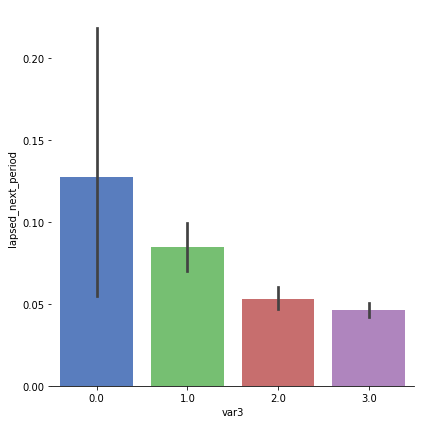

In [35]:
def segment_barplot(var):
    g = sns.factorplot(x=var, y='lapsed_next_period', data=df,
                       kind='bar', size=6, palette='muted')
    g.despine(left=True)

segment_barplot('var3')

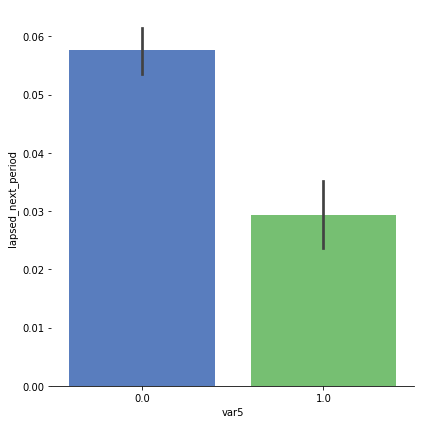

In [37]:
segment_barplot('var5')

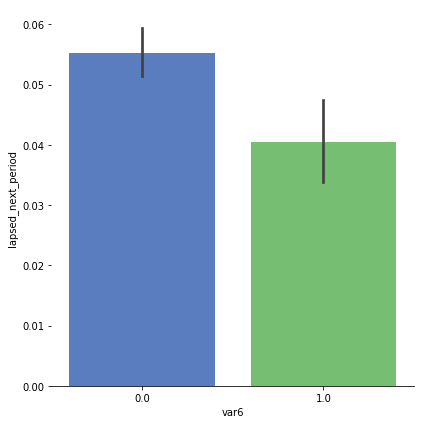

In [38]:
segment_barplot('var6')

In [34]:
g = sns.kdeplot(df['var4'][df['lapsed_next_period'] == 0], color="Red", shade = True)
g = sns.kdeplot(df['var4'][df['lapsed_next_period'] == 1], ax =g, color="Blue", shade= True)
g.despine(left=True)

NameError: name 'df' is not defined